In [121]:
import numpy as np
import pandas as pd
import scanpy as sc
import re
import anndata as ad

import gseapy as gp
from gseapy import dotplot
import time

from scipy.stats import ranksums
from statsmodels.stats.multitest import fdrcorrection

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

sc.settings.verbosity = 2  # reduce the verbosity
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

import warnings
warnings.filterwarnings('ignore')

scanpy==1.9.5 anndata==0.9.2 umap==0.5.3 numpy==1.21.5 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.0.2 statsmodels==0.13.2 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.10


# Functions

In [152]:
# Read and filter data (basic)
# Concatenate the two mixes (for G12C and G12D)
def read_data(condition, replicate_num = None, cache=True, unique=True, filter_mat=True, cells=3, genes=150):
    
    cond_to_path_dict = {'G12C': 'data/Mix/G12C/sample_filtered_feature_bc_matrix/',
                         'G12D': 'data/Mix/G12D/sample_filtered_feature_bc_matrix/',
                         'G12R': 'data/J951_G12R_mix_GEX/filtered_feature_bc_matrix'}
        
    if replicate_num is None:
        if condition == 'G12R':
            batch = condition
            adata = sc.read_10x_mtx(
                cond_to_path_dict[condition],
                var_names='gene_symbols',
                cache=cache)
                
            adata.obs.loc[:,'n_batch'] = batch

        elif condition == 'G12C' or condition == 'G12D':
            adata = None
            path = cond_to_path_dict[condition]
            for mix in [1,2]:
                for replicate in [1,2,3]:
                    batch = f'{condition}_{mix}_{replicate}'
                    p = re.sub('Mix', f'Mix{mix}', path)
                    p = re.sub(condition, f'{condition}_{replicate}', p)
                    print(f'Reading from {p}')
                    a = sc.read_10x_mtx(
                        p,
                        var_names='gene_symbols',
                        cache=cache)
                    a.obs.loc[:,'n_batch'] = batch

                    if adata:
                        adata = adata.concatenate(a)
                    else:
                        adata = a
                        
        else:
            adata = None
            path = cond_to_path_dict['G12C']
            for mix in [1,2]:
                for replicate in [1,2,3]:
                    batch = f'G12C_{mix}_{replicate}'
                    p = re.sub('Mix', f'Mix{mix}', path)
                    p = re.sub('G12C', f'G12C_{replicate}', p)
                    print(f'Reading from {p}')
                    a = sc.read_10x_mtx(
                        p,
                        var_names='gene_symbols',
                        cache=cache)
                    a.obs.loc[:,'n_batch'] = batch

                    if adata:
                        adata = adata.concatenate(a)
                    else:
                        adata = a
                        
            path = cond_to_path_dict['G12D']
            for mix in [1,2]:
                for replicate in [1,2,3]:
                    batch = f'G12D_{mix}_{replicate}'
                    p = re.sub('Mix', f'Mix{mix}', path)
                    p = re.sub('G12D', f'G12D_{replicate}', p)
                    print(f'Reading from {p}')
                    a = sc.read_10x_mtx(
                        p,
                        var_names='gene_symbols',
                        cache=cache)
                    a.obs.loc[:,'n_batch'] = batch

                    adata = adata.concatenate(a)

            batch = 'G12R'
            a = sc.read_10x_mtx(
                cond_to_path_dict['G12R'],
                var_names='gene_symbols',
                cache=cache)
            
            a.obs.loc[:,'n_batch'] = batch
            
            adata = adata.concatenate(a)

                
                        
    else:
        path1 = re.sub('Mix', 'Mix1', cond_to_path_dict[condition])
        path1 = re.sub(condition, f'{condition}_{replicate_num}', path1)
        
        path2 = re.sub('Mix', 'Mix2', cond_to_path_dict[condition])
        path2 = re.sub(condition, f'{condition}_{replicate_num}', path2)
        
        adata1 = sc.read_10x_mtx(
            path1,
            var_names='gene_symbols',
            cache=cache)
        
        adata1.obs.loc[:,'n_batch'] = f'{condition}_1_{replicate}'

        
        adata2 = sc.read_10x_mtx(
            path2,
            var_names='gene_symbols',
            cache=cache)
        
        adata1.obs.loc[:,'n_batch'] = f'{condition}_2_{replicate}'

        adata = adata1.concatenate(adata2)
    
    if unique:
        adata.var_names_make_unique()
    
    print(adata)
    
    sc.pl.highest_expr_genes(adata, n_top=20)

    if filter_mat:
        sc.pp.filter_cells(adata, min_genes=genes)
        sc.pp.filter_genes(adata, min_cells=cells)
        
        print(f'\nAfter filter:\n\n{adata}')
        
    return adata


# filter mt genes and plot
def mt_initial_preprocess_and_plot(adata, var='mt', pattern='mt-', violin=True, scatter=True):
    adata.var[var] = adata.var_names.str.startswith(pattern)  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=[var], percent_top=None, log1p=False, inplace=True)
    
    if violin:
        sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
    
    if scatter:    
        sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
        sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
    
    print('mt_initial_preprocess_and_plot shape')
    display(adata)
    return adata


# filter, normalize, logarithmize and scale
def preprocess(adata, n_genes_by_counts=5e4, pct_counts_mt=20, normalize=True, target_sum=1e4, 
                         logarithmize=True, dynamic=True, min_mean=1, max_mean=6, min_disp=0.4):
    adata = adata[adata.obs.n_genes_by_counts < n_genes_by_counts, :]
    adata = adata[adata.obs.pct_counts_mt < pct_counts_mt, :]
    print('preprocess shape')
    display(adata)

    if normalize:
        sc.pp.normalize_total(adata, target_sum=target_sum)
        
    if logarithmize:
        sc.pp.log1p(adata)
    
    if dynamic:
        sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)

    sc.pl.highly_variable_genes(adata)

    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]

    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

    sc.pp.scale(adata, max_value=10)

    return adata


# neighborhood graph
def neighborhood_graph_and_clustering(adata, n_neighbors=10, n_pcs=40, plot=False, color=['Sgk3'], use_raw=False, perplexity=10): # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata, log=True)

    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
    
    sc.tl.louvain(adata)
    sc.tl.leiden(adata)
    sc.tl.tsne(adata, perplexity=perplexity, random_state=0)
    sc.pl.tsne(adata, color=color, use_raw=use_raw)

    sc.tl.paga(adata)
    sc.pl.paga(adata, plot=plot)  
    sc.tl.umap(adata, init_pos='paga', random_state=0)    
    sc.pl.umap(adata, color=color, use_raw=use_raw)

    return adata


def markers(adata, clusters='leiden', method='wilcoxon', n_genes=25): # Other possibilities are 'logreg' and 't-test'
    sc.tl.rank_genes_groups(adata, clusters, method=method)
    sc.pl.rank_genes_groups(adata, n_genes=n_genes, sharey=False)
    
    top_genes_df = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

    return adata, top_genes_df


def reannotate_and_visualize_clusters(adata, cluster_map):
    adata.obs['leiden'] = adata.obs['leiden'].astype(int).replace(cluster_map)
    sc.pl.tsne(adata, color=['leiden'], use_raw=True, palette='Set1')
    
    return adata


def reannotate_subset_and_visualize(adata, adata_sub, cluster_map_sub):
    adata_sub_names = adata_sub.obs['leiden'].astype(int).replace(cluster_map_sub)
    names = pd.concat([adata.obs['leiden'],(adata_sub_names)]).to_frame().reset_index().drop_duplicates(subset=['index'], keep='last').set_index('index')
    adata.obs = adata.obs.merge(names, left_index=True, right_index=True).drop(columns=['leiden_x']).rename({'leiden_y': 'leiden'}, axis=1)
    sc.pl.tsne(adata, color=['leiden'], use_raw=True, palette='Set1')
    
    return adata


def subset_analysis(adata, subset, perplexity=30, color=['leiden'], use_raw=True, resolution=1):
    subset_clusters = [sub for sub in adata.obs['leiden'].unique() if subset.lower() in sub.lower()]
    adata_subset = adata[adata.obs['leiden'].isin(subset_clusters)]
    
    sc.tl.leiden(adata_subset,resolution=resolution)
    sc.tl.tsne(adata_subset, perplexity=perplexity, random_state=0)
    sc.pl.tsne(adata_subset, color=color, use_raw=use_raw)
    
    return adata_subset


def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


def get_subset_indices(adata, cluster, cond='leiden'):
    obs_sub = adata.obs_names[adata.obs[cond].astype(int)==cluster]
    obs_rest = adata.obs_names[~adata.obs_names.isin(obs_sub)]
    
    obs_df = adata.obs.reset_index()
    sub_ind = obs_df[obs_df['index'].isin(obs_sub)].index.tolist()
    rest_ind = obs_df[obs_df['index'].isin(obs_rest)].index.tolist()

    return sub_ind, rest_ind


def calc_pval_and_effect(mat, sub_inds, rest_inds, gene_ind):
    samp1 = mat[sub_inds, gene_ind]
    samp2 = mat[rest_inds, gene_ind]

    pval = ranksums(samp1, samp2).pvalue
    effect = cohen_d(samp1, samp2)
    
    return pval, effect


def pval_and_effect_df(adata, cluster):
    df_diff = pd.DataFrame(index=adata.var_names, columns=['pval', 'effect'])
    sub_inds, rest_inds = get_subset_indices(adata, cluster)
    for i, gene in enumerate(df_diff.index):
        pval, effect = calc_pval_and_effect(adata.X, sub_inds, rest_inds, i)
        df_diff.loc[gene, ['pval', 'effect']] = [pval, effect]
    df_diff['fdr'] = fdrcorrection(df_diff['pval'])[1]
    
    return df_diff


def differential_genes(df, fdr=0.05, effect=0.5):
    diff_genes = df[np.logical_and(df['fdr']<fdr, np.abs(df['effect'])>effect)]['effect'].to_frame().sort_values(by='effect',ascending=False)
    diff_genes['effect'] = diff_genes['effect'].astype('float')
    diff_genes.index = diff_genes.index.str.upper()

    return diff_genes


def gsea_plot(diff_df, 
              title,
              ofname=None,
              gene_sets=['MSigDB_Oncogenic_Signatures','GO_Biological_Process_2023','GO_Molecular_Function_2023','KEGG_2021_Human','MSigDB_Hallmark_2020'], 
              threads=4,
              min_size=5,
              max_size=1000,
              permutation_num=1000, # reduce number to speed up testing
              outdir=None, # don't write to disk
              seed=6,
              verbose=False,
              column="NOM p-val",
              size=5,
              figsize=(10,10), 
              cutoff=1):
    
    pre_res = gp.prerank(rnk=diff_df, gene_sets=gene_sets, threads=threads, min_size=min_size, max_size=max_size, 
                         permutation_num=permutation_num, outdir=outdir, seed=seed, verbose=verbose)
    
    dotplot(pre_res.res2d, title=title, ofname=ofname, column=column, size=size, figsize=figsize, cutoff=cutoff)


## Run pipeline (no dot plot)

In [ ]:
results_map = {}
conditions = ['G12C', 'G12D', 'G12R']

for cond in conditions:
    print(f'Running {cond}\n----------------------------------------------------------------------------\n')
    adata = read_data(cond, replicate_num=None)
    adata = mt_initial_preprocess_and_plot(adata)
    adata = preprocess(adata, min_mean=0.3, min_disp=0.3)
    adata = neighborhood_graph_and_clustering(adata, color=['Cd4', 'Cd8a', 'Krt4', 'louvain', 'leiden','n_batch'], 
                                              n_pcs=10, use_raw=True, perplexity=30)
    adata, top_genes_df = markers(adata)

    display(top_genes_df)

    results_map[cond] = {}
    results_map[cond]['adata'] = adata
    results_map[cond]['top_genes_df'] = top_genes_df


## New clusters by Maayan

In [ ]:
G12C_clusters = {
    0: 'Fibroblasts',
    1: 'Macrophages M1 (Immune)', 
    2: 'Cancer',
    3: 'Cancer',
    4: 'Cancer',
    5: 'Macrophages M2 (Immune)',
    6: 'Cancer',
    7: 'B cells (Immune)',
    8: 'Cancer',
    9: 'Cancer',
    10: 'Cancer',
    11: 'MDSCs (Immune)',
    12: 'Macrophages M2 (Immune)',
    13: 'Endothelial', 
    14: 'Cancer',
    15: 'Cancer',
    16: 'Cancer',
    17: 'T cells  (Immune)',
    18: 'Dendritic cells (Immune)',
    19: 'B cells (Immune)',
    20: 'Cancer', 
    21: 'Fibroblasts (stellate)',
    22: 'MDSCs (Immune)'
}


G12D_clusters = {
    0: 'MDSCs (Immune)',
    1: 'Cancer',
    2: 'Cancer',
    3: 'Macrophages M2 (Immune)',
    4: 'Macrophages M2 (Immune)',
    5: 'Immune',
    6: 'MDSCs (Immune)',
    7: 'T cells (Immune)',
    8: 'Cancer',
    9: 'Cancer', 
    10: 'Cancer',
    11: 'Cancer',
    12: 'Cancer',
    13: 'Endothelial',
    14: 'MDSCs (Immune)',
    15: 'Immune',
    16: 'Immune',
    17: 'Dendritic cells (Immune)',
    18: 'Cancer',
    19: 'Immune',
    20: 'Immune',
    21: 'Cancer',
    22: 'Acinar',
    23: 'Immune'
}


G12R_clusters = {
    0: 'T cells (Immune)',
    1: 'MDSCs (Immune)',
    2: 'Cancer',
    3: 'Cancer',
    4: 'B cells (Immune)',
    5: 'Macrophages M2 (Immune)',
    6: 'Cancer',
    7: 'Cancer',
    8: 'B cells (Immune)',
    9: 'B cells (Immune)',
    10: 'T cells (Immune)',
    11: 'Cancer',
    12: 'mix (Immune)',
    13: 'Fibroblasts',
    14: 'Cancer',
    15: 'Cancer',
    16: 'Cancer',
    17: 'Cancer',
    18: 'mix (Immune)',
    19: 'Endothelial',
    20: 'NK cells (Immune)',
    21: 'Macrophage M1 (Immune)',
    22: 'Acinar', 
    23: 'NK cells (Immune)',
    24: 'B cells (Immune)'
}

In [ ]:
G12C = results_map['G12C']['adata'].copy()
G12D = results_map['G12D']['adata'].copy()
G12R = results_map['G12R']['adata'].copy()

## TSNE with new cluster annotations and filtered for immune cells

In [ ]:
marker_genes_immune = [
    'Krt19', 'Pecam1', 'Vwf', 'Col1a2', 'Ptprc', 
    'Cd19', 'Cd68', 'Cd14', 'Cd163', 'Il6', 
    'Inhba', 'Arg1', 'S100a8', 'Cd3e', 'Tnf',
    'Try4', 'Try5', 'Try10', 'Cpa1', 'Tm4sf1', 
    'Sox4', 'Sox9', 'H2-Eb1', 'Muc4', 'Cd4', 
    'Cd8a', 'Il2ra', 'Kit', 'Mki67', 'Ins1', 
    'Pdgfrb', 'Tpsab1', 'Cpa3', 'Itgae', 'Nkg7']

for cond in conditions:
    if cond == 'G12C':
        print('G12C')
        G12C = reannotate_and_visualize_clusters(G12C, G12C_clusters)
        G12C_immune = subset_analysis(G12C, 'immune')
        G12C_immune, G12C_immune_top_genes_df = markers(G12C_immune)
        display(G12C_immune_top_genes_df)
        sc.pl.dotplot(G12C_immune, marker_genes_immune, groupby='leiden')
    if cond == 'G12D':
        print('G12D')
        G12D = reannotate_and_visualize_clusters(G12D, G12D_clusters)
        G12D_immune = subset_analysis(G12D, 'immune')
        G12D_immune, G12D_immune_top_genes_df = markers(G12D_immune)
        display(G12D_immune_top_genes_df)
        sc.pl.dotplot(G12D_immune, marker_genes_immune, groupby='leiden')
    if cond == 'G12R':
        print('G12R')
        G12R = reannotate_and_visualize_clusters(G12R, G12R_clusters)
        G12R_immune = subset_analysis(G12R, 'immune')
        G12R_immune, G12R_immune_top_genes_df = markers(G12R_immune)
        display(G12R_immune_top_genes_df)
        sc.pl.dotplot(G12R_immune, marker_genes_immune, groupby='leiden')

## New immune clusters by Maayan

In [ ]:
G12C_immune_clusters = {
    0: 'Macrophages M2',
    1: 'Macrophages M2', 
    2: 'Macrophages M2',
    3: 'MDSCs',
    4: 'MDSCs',
    5: 'Macrophages M2',
    6: 'MDSCs',
    7: 'Macrophages M2',
    8: 'Macrophages M2',
    9: 'B-cells',
    10: 'MDSCs',
    11: 'B-cells',
    12: 'Cd4 T-cells',
    13: 'Cd8 T-cells', 
    14: 'MDSCs',
    15: 'MDSCs',
    16: 'Macrophages M2'
}


G12D_immune_clusters = {
    0: 'MDSCs',
    1: 'MDSCs',
    2: 'Fibroblasts',
    3: 'Macrophages M1',
    4: 'MDSCs',
    5: 'Cd8 T-cells',
    6: 'MDSCs',
    7: 'MDSCs',
    8: 'Cd4 T-cells',
    9: 'B-cells', 
    10: 'MDSCs',
    11: 'B-cells',
    12: 'B-cells',
    13: 'Fibroblasts',
    14: 'Cancer',
    15: 'B-cells',
    16: 'Acinar',
    17: 'B-cells',
    18: 'Fibroblasts',
    19: 'Cd8 T-cells'
}


G12R_immune_clusters = {
}

## Immune cells re-mapping and TSNE after cluster annotations

In [ ]:
for cond in conditions:
    if cond == 'G12C':
        print('G12C')
        G12C = reannotate_subset_and_visualize(G12C, G12C_immune, G12C_immune_clusters)
    if cond == 'G12D':
        print('G12D')
        G12D = reannotate_subset_and_visualize(G12D, G12D_immune, G12D_immune_clusters)
    if cond == 'G12R':
        continue
        print('G12R')
        G12R = reannotate_subset_and_visualize(G12R, G12R_immune, G12R_immune_clusters)

## Filtered for cancer cells

In [ ]:
for cond in conditions:
    if cond == 'G12C':
        print('G12C')
        G12C_cancer = subset_analysis(G12C, 'cancer', resolution=0.25)
        G12C_cancer, top_genes_df_c = markers(G12C_cancer)
    if cond == 'G12D':
        print('G12D')
        G12D_cancer = subset_analysis(G12D, 'cancer', resolution=0.25)
        G12D_cancer, top_genes_df_d = markers(G12D_cancer)
    if cond == 'G12R':
        print('G12R')
        G12R_cancer = subset_analysis(G12R, 'cancer', resolution=0.25)
        G12R_cancer, top_genes_df_r = markers(G12R_cancer)

## Cancer cells GSEA analysis

In [150]:
cancer_adata_objs = {'G12C': G12C_cancer, 
                     'G12D': G12D_cancer} 
                     #,'G12R': G12R_cancer}

for cond, obj in cancer_adata_objs.items():
    clusters = obj.obs['leiden'].unique()
    for cluster in clusters:
        df = pval_and_effect_df(obj, int(cluster))
        df_diff = differential_genes(df)
        gsea_plot(df_diff, f'{cond} with cluster {cluster}:\n')

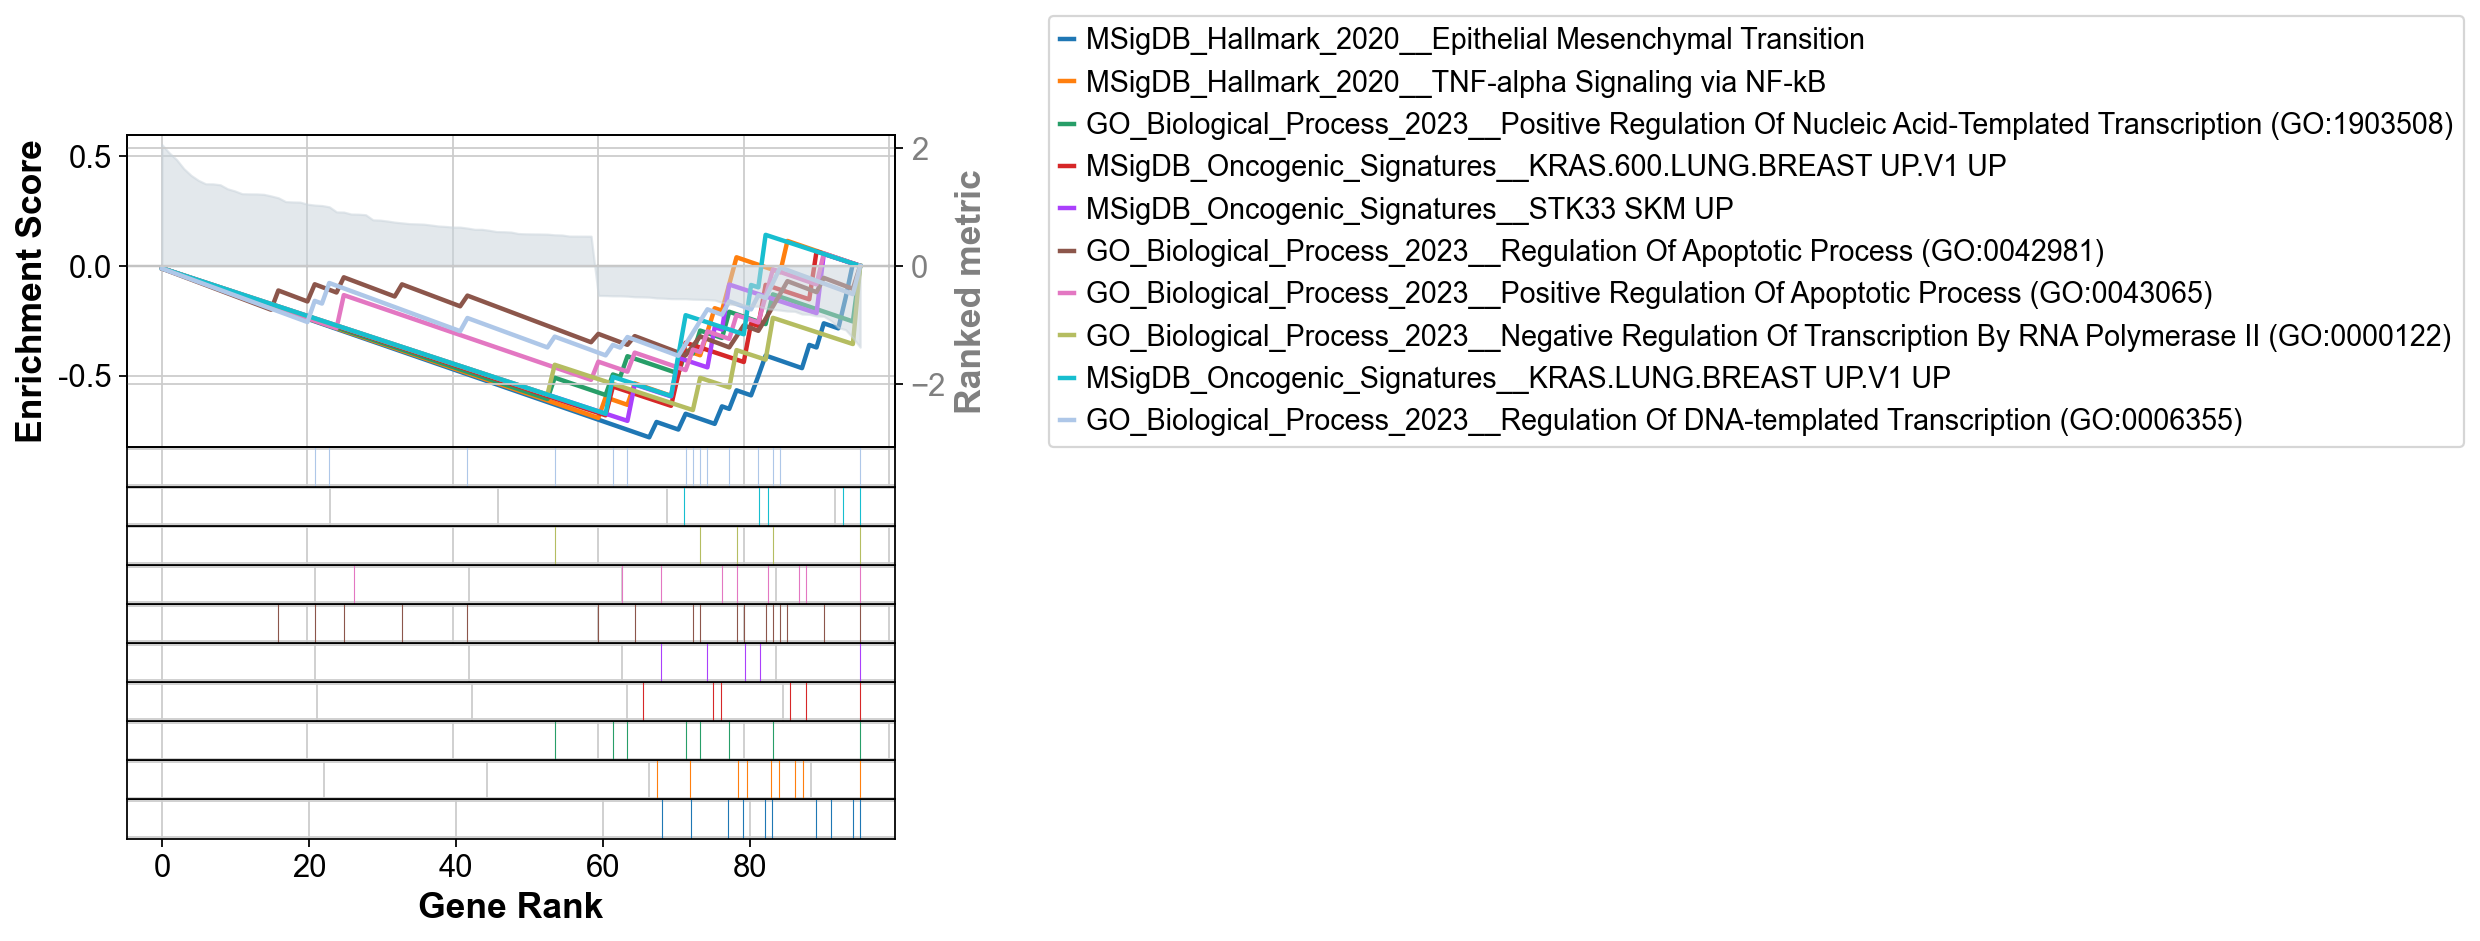

In [70]:
#plotting top10 for one group
terms = pre_res.res2d.sort_values(by='NES')[0:10].Term
axs = pre_res.plot(terms=terms,
                   legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )

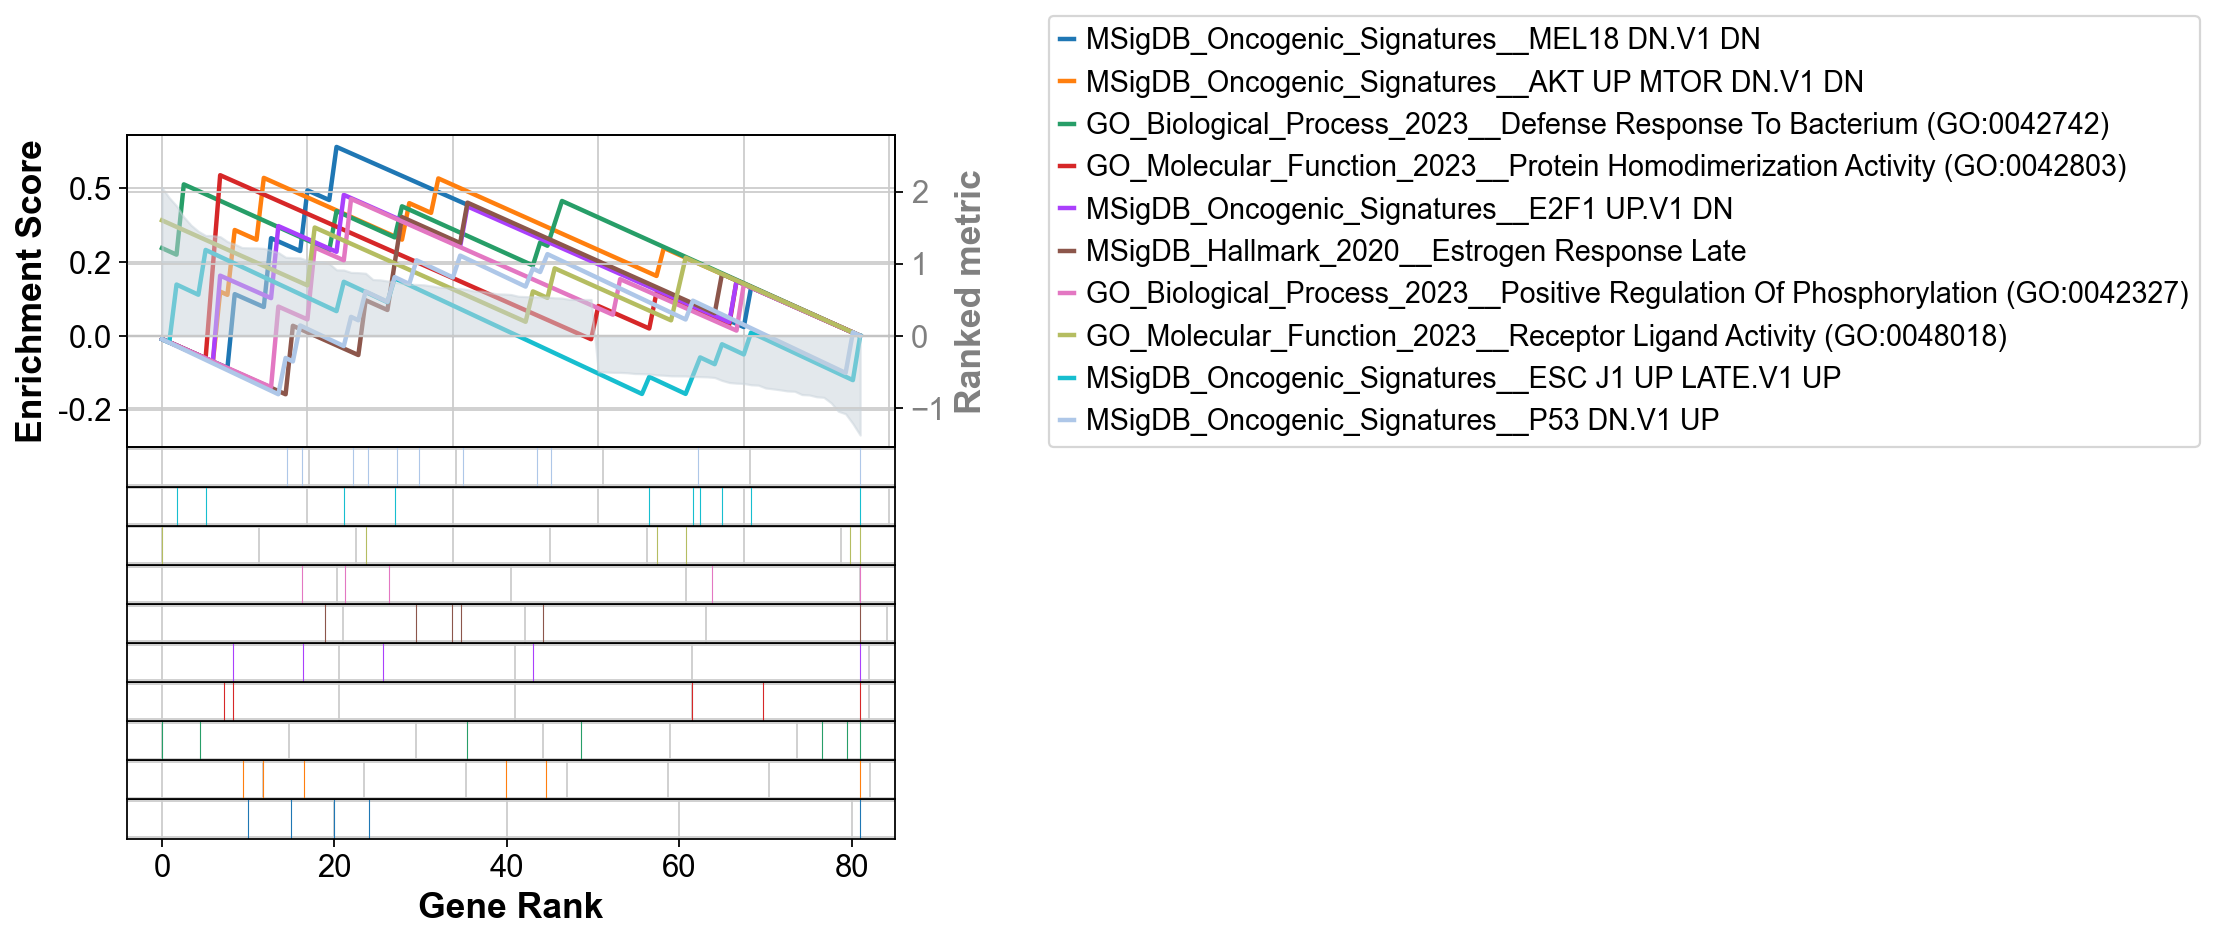

In [66]:
#plotting top10 for the other group group
terms = pre_res.res2d.sort_values(by='NES',ascending=False)[0:10].Term
axs = pre_res.plot(terms=terms,
                   legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )

In [ ]:
#Second part - running GSEA
diff_genes = df_diff[np.logical_and(df_diff['FDR']<0.05,np.abs(df_diff['effect'])>0.8)]['effect'].to_frame().sort_values(by='effect')
diff_genes['effect'] = diff_genes['effect'].astype('float')
diff_genes.index = diff_genes.index.str[0:-3]
pre_res = gp.prerank(rnk=diff_genes,
                     gene_sets=['MSigDB_Oncogenic_Signatures','GO_Biological_Process_2023','GO_Molecular_Function_2023','KEGG_2021_Human','MSigDB_Hallmark_2020'],
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=False,
                    )

#plotting top10 for one group
terms = pre_res.res2d.sort_values(by='NES')[0:10].Term
axs = pre_res.plot(terms=terms,
                   legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )

#plotting top10 for the other group group
terms = pre_res.res2d.sort_values(by='NES',ascending=False)[0:10].Term
axs = pre_res.plot(terms=terms,
                   legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )

In [ ]:
#First part - finding differential genes and calculating effect size:

df_to_ana = df_out[cols].copy()

group1 = df_out[np.logical_and(df_out['sotorasib_sensitivity'] == 'sensitive',df_out['adagrasib_sensitivity'] == 'not_sensitive')].index
group2 = df_out[np.logical_and(df_out['sotorasib_sensitivity'] == 'not_sensitive',df_out['adagrasib_sensitivity'] == 'sensitive')].index

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


from scipy.stats import ranksums
df_diff = pd.DataFrame(index=df_to_ana.columns,columns=['pval','effect'])
for gene in df_to_ana:
    sample1 = df_to_ana.loc[group1,gene]
    sample2 = df_to_ana.loc[group2,gene]
    df_diff.loc[gene,'pval'] = ranksums(sample1, sample2).pvalue
    df_diff.loc[gene,'effect'] = cohen_d(sample1, sample2)

from statsmodels.stats.multitest import fdrcorrection
df_diff['FDR'] = fdrcorrection(df_diff['pval'])[1]

## Save top ranked genes to csv

In [ ]:
#results_map['G12C']['top_genes_df'].to_csv('G12C.csv', index=False)
#results_map['G12D']['top_genes_df'].to_csv('G12D.csv', index=False)
#results_map['G12R']['top_genes_df'].to_csv('G12R.csv', index=False)